### Model 1. Prices only (po) model modified to be comparable with Prices Plus Fin. Statements (ppfs) model. 

PO model 1 is different from initial prices only model in 3 things:
- fewer number of stocks - only those that are present in ppfs model are here
- different dataset - {t}_p_fs.csv files are from 2010 to 2017.
- Instead of being quarterly it is now monthly, as I let go the need to forecast for 90 days+ because quarterly data didn't give me enough values to train the model, to predict properly. 

Making necessary imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import math
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# from scipy import stats

Defining the list of companies to predict the stock price for. (Temporarily narrowed down to one stock for testing of the model)

In [3]:
tickers = ['aapl']                                                                                       # stock from Fin. statements dataset
# , 'msft', 'goog', 'aig', 'pcg', 'mcd', 'bcs', 'nvda', 'intc', 'amzn']                                           # stocks from Fin. statements dataset

Reading csv files with stock price data, converting date to datetime, cleaning from unneeded columns.

In [7]:
stock_dfs = {}
for t in tickers:
    # read csv files
    stock_dfs[t]=pd.read_csv(f'../data/clean_csv/{t}_p_fs.csv')
    # convert date to datetime
    stock_dfs[t]["Date"] = pd.to_datetime(stock_dfs[t]["Date"])
    # Drop irrelevant columns
    stock_dfs[t].drop(columns=['Unnamed: 0', 'OpenInt', 'Open', 'High', 'Low'],inplace=True)
    # Set 'Date' as index
    stock_dfs[t].set_index('Date', inplace=True)
    # Resample to quarterly data and keep the last price in each quarter
    stock_dfs[t] = stock_dfs[t].resample('ME').last()

    # Reset index to make 'Date' a column again
    stock_dfs[t].reset_index(inplace=True)

    print(f'{t}')
    print(stock_dfs[t].shape)

aapl
(98, 24)


Splitting the data into train and test. Cannot do it without train_test_split function, as it does not maintain the sequence of data, because of it's randomization parameter. 

In [9]:
train_dfs = {}
test_dfs = {}

for t in tickers:
    
    # Train-test split manually
    len_data = len(stock_dfs[t])     #Count of rows that data has
    len_train = round(len_data * 0.75)   # %75 train + %25 test
    len_test = len_data - len_train
   
    print(f'Total rows: {len_data}; Train rows: {len_train}; Test rows: {len_test}.')

    train_dfs[t] = stock_dfs[t][:len_train]
    test_dfs[t] = stock_dfs[t][len_train:]
    # printing to show that train and test dfs do not intersect
    print(t)
    print(train_dfs[t].tail(5))
    print(test_dfs[t].head(5))

Total rows: 98; Train rows: 74; Test rows: 24.
aapl
         Date   Close    Volume  C_returns  Market Cap(in B USD)   Revenue  \
69 2015-07-31  115.76  44937189  -0.008734                647.36  182795.0   
70 2015-08-31  108.09  58654593  -0.004696                647.36  182795.0   
71 2015-09-30  105.74  69340249   0.011382                647.36  182795.0   
72 2015-10-31  114.56  51494522  -0.008482                586.86  233715.0   
73 2015-11-30  113.90  40696103   0.004321                586.86  233715.0   

    Gross Profit  Net Income  Earning Per Share   EBITDA  ...  Current Ratio  \
69       70537.0     39510.0             1.6125  60449.0  ...         1.0801   
70       70537.0     39510.0             1.6125  60449.0  ...         1.0801   
71       70537.0     39510.0             1.6125  60449.0  ...         1.0801   
72       93626.0     53394.0             2.3050  82487.0  ...         1.1088   
73       93626.0     53394.0             2.3050  82487.0  ...         1.1088   

Reshaping the datasets for the model

In [11]:
train_datasets = {}
test_datasets = {}

# Creating datasets and shaping their form for the model.
for t in tickers:
    train_datasets[t] = train_dfs[t]['Close'].values
    train_datasets[t] = np.reshape(train_datasets[t], (-1, 1))

    test_datasets[t] = test_dfs[t]['Close'].values
    test_datasets[t] = np.reshape(test_datasets[t], (-1, 1))

Scaling train data. Applying lookback window. Reshaping for model.

In [13]:
train_datasets_scaled = {}
scales = {}

X_trains = {}
y_trains = {}

Lookback = 10

for t in tickers:
    # Scaling train Dataset
    scales[t] = MinMaxScaler(feature_range = (0,1))
    train_datasets_scaled[t] = scales[t].fit_transform(train_datasets[t])
    X_trains[t] = []
    y_trains[t] = []
    len_train = len(train_datasets_scaled[t])

    # Creating a moving window of size Lookback for the forecast
    for i in range(Lookback, len_train):
        X_trains[t].append(train_datasets_scaled[t][i - Lookback:i, 0])
        y_trains[t].append(train_datasets_scaled[t][i, 0])

    # Converting to Numpy array and reshaping for model
    X_trains[t], y_trains[t] = np.array(X_trains[t]), np.array(y_trains[t])
    X_trains[t] = np.reshape(X_trains[t], (X_trains[t].shape[0], X_trains[t].shape[1],1))
    y_trains[t] = np.reshape(y_trains[t], (y_trains[t].shape[0],1))
    print("Shape of X_trains:",X_trains[t].shape)
    print("Shape of y_trains:",y_trains[t].shape)
    

Shape of X_trains: (64, 10, 1)
Shape of y_trains: (64, 1)


In [14]:
test_datasets_scaled = {}
test_scales = {}

X_tests = {}
y_tests = {}

for t in tickers:
    # Scaling test Dataset
    test_scales[t] = MinMaxScaler(feature_range = (0,1))
    test_datasets_scaled[t] = test_scales[t].fit_transform(test_datasets[t])
    X_tests[t] = []
    y_tests[t] = []
    len_test = len(test_datasets_scaled[t])

    # Creating a moving window of size Lookback for the forecast
    for i in range(Lookback, len_test):
        X_tests[t].append(test_datasets_scaled[t][i - Lookback:i, 0])
        y_tests[t].append(test_datasets_scaled[t][i, 0])

    # Converting to Numpy array and reshaping for model
    X_tests[t], y_tests[t] = np.array(X_tests[t]), np.array(y_tests[t])
    X_tests[t] = np.reshape(X_tests[t], (X_tests[t].shape[0], X_tests[t].shape[1],1))
    y_tests[t] = np.reshape(y_tests[t], (y_tests[t].shape[0],1))
    print({t})
    print("Shape of X_tests:",X_tests[t].shape)
    print("Shape of y_tests:",y_tests[t].shape)

{'aapl'}
Shape of X_tests: (14, 10, 1)
Shape of y_tests: (14, 1)


Building the model itself.

In [16]:
models = {}
histories = {}

for t in tickers:
    # initiate RNN
    models[t] = Sequential()
    
    # adding first RNN layer and dropout regulatization
    models[t].add(
        SimpleRNN(units = Lookback, 
                  activation = "tanh", 
                  return_sequences = True, 
                  input_shape = (X_trains[t].shape[1],1))
                 )
    
    models[t].add(
        Dropout(0.2)
                 )
    
    
    # adding second and third RNN layer and dropout regulatization
    
    models[t].add(
        SimpleRNN(units = Lookback, 
                  activation = "tanh", 
                  return_sequences = True)
                 )
    
    models[t].add(
        Dropout(0.2)
                 )

    models[t].add(
        SimpleRNN(units = Lookback, 
                  activation = "tanh", 
                  return_sequences = True)
                 )
    
    models[t].add(
        Dropout(0.2)
                 )
    
    # adding forth RNN layer and dropout regulatization
    
    models[t].add(
        SimpleRNN(units = Lookback)
                 )
    
    models[t].add(
        Dropout(0.2)
                 )
    
    # adding the output layer
    models[t].add(Dense(units = 1))
    
    # compiling RNN
    models[t].compile(
        optimizer = "adam", 
        loss = "mean_squared_error",
        metrics = ["accuracy"])
    
    # fitting the RNN
    histories[t] = models[t].fit(X_trains[t], y_trains[t], epochs = 50, batch_size = 32, verbose=0)

C:\Users\Vladimir\anaconda3\envs\ml_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


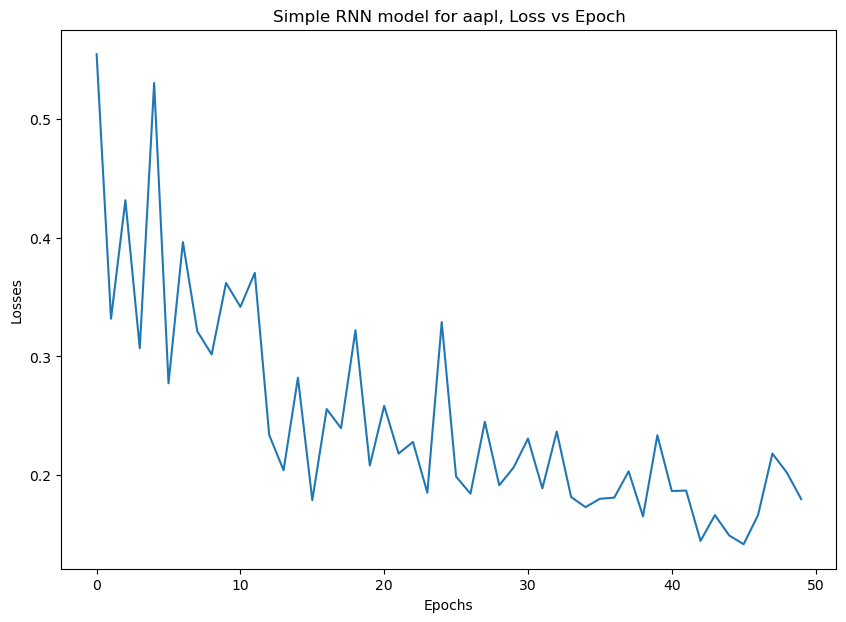

In [17]:
for t in tickers:
    # Plotting Loss vs Epochs
    plt.figure(figsize =(10,7))
    plt.plot(histories[t].history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.title(f"Simple RNN model for {t}, Loss vs Epoch")
    plt.show()

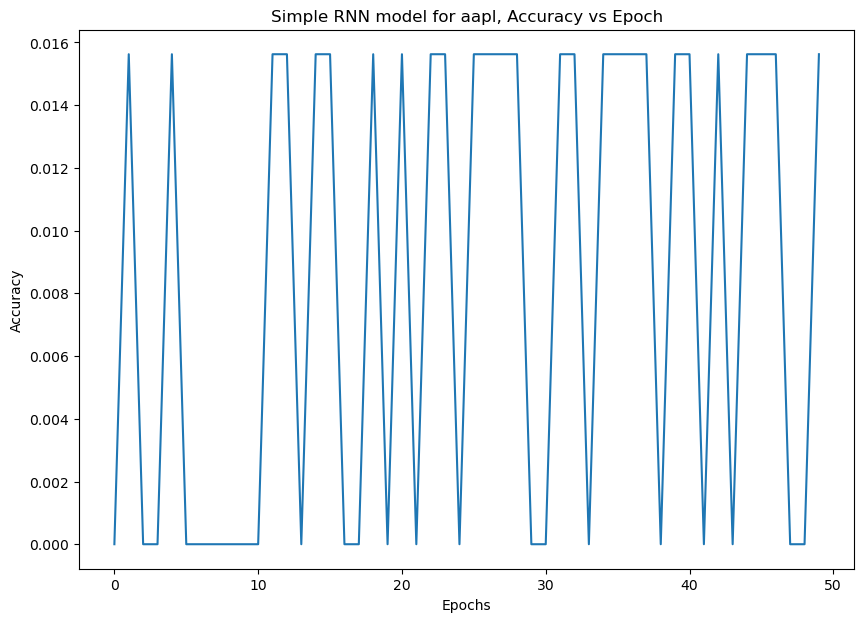

In [18]:
for t in tickers:
    # Plotting Accuracy vs Epochs
    plt.figure(figsize =(10,7))
    plt.plot(histories[t].history["accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Simple RNN model for {t}, Accuracy vs Epoch")
    plt.show()

Making train predictions. Visualizing train data and prediction.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


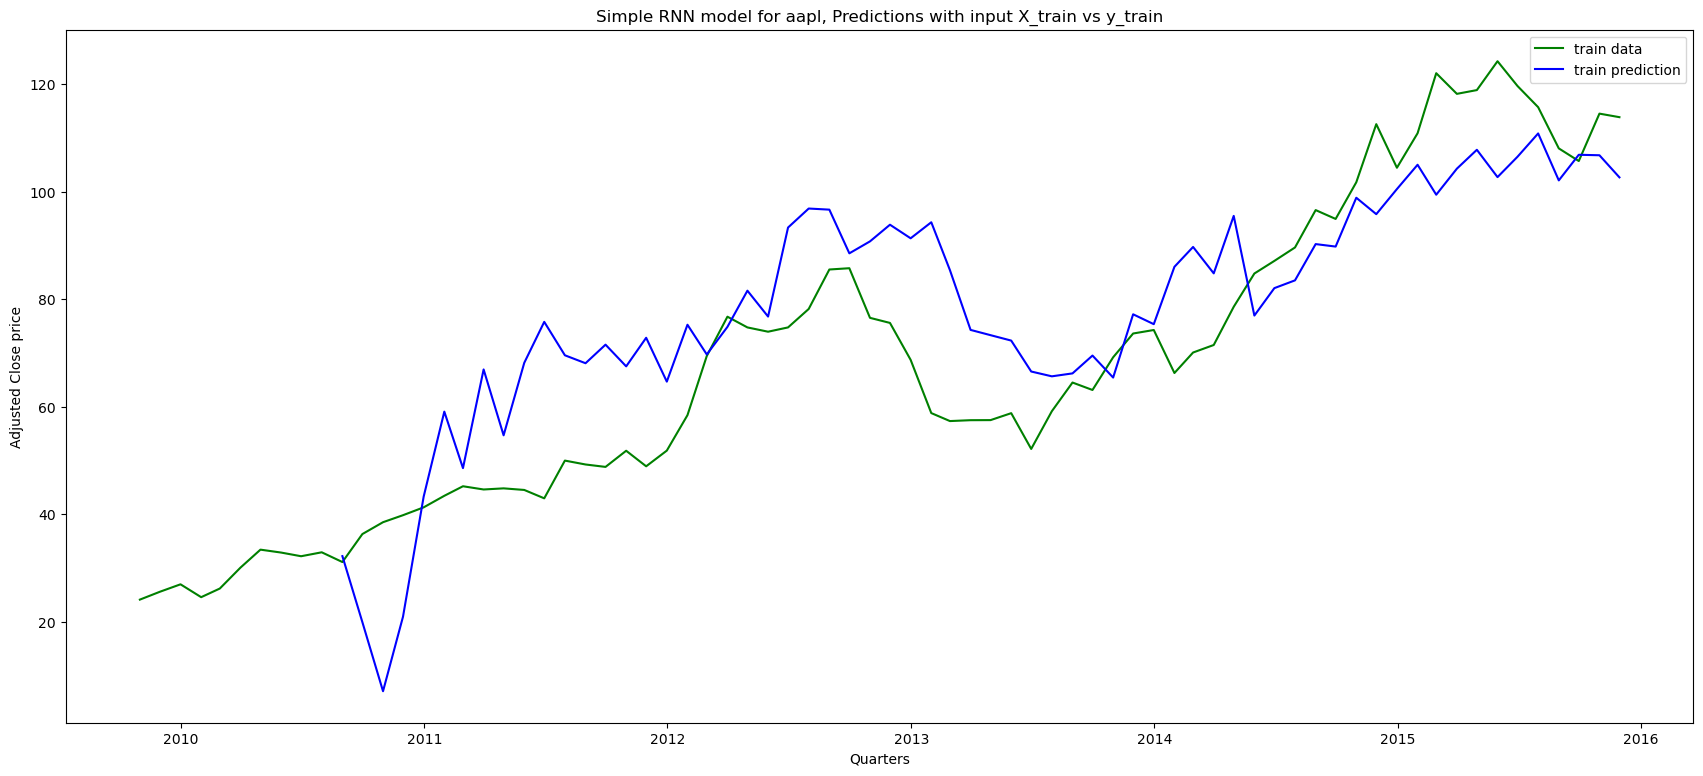

In [20]:
y_preds = {}

for t in tickers:
    y_preds[t] = models[t].predict(X_trains[t])  # predictions
    y_preds[t] = scales[t].inverse_transform(y_preds[t]) # scaling back from 0-1 to original
    
    # Visualizing predictions in train dataset
    plt.figure(figsize = (21,9))
    plt.plot(train_dfs[t]['Date'],train_dfs[t]['Close'], color = "g", label = "train data")
    plt.plot(train_dfs[t]['Date'].iloc[Lookback:],y_preds[t], color = "b", label = "train prediction" )
    plt.xlabel("Quarters")
    plt.ylabel("Adjusted Close price")
    plt.title(f"Simple RNN model for {t}, Predictions with input X_train vs y_train")
    plt.legend()
    plt.show()

Making test predictions.

In [22]:
y_test_preds = {}

for t in tickers:
    # predictions for test
    y_test_preds[t] = models[t].predict(X_tests[t])
    y_test_preds[t] = test_scales[t].inverse_transform(y_test_preds[t])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


Making combined charts with train and test data and predictions.

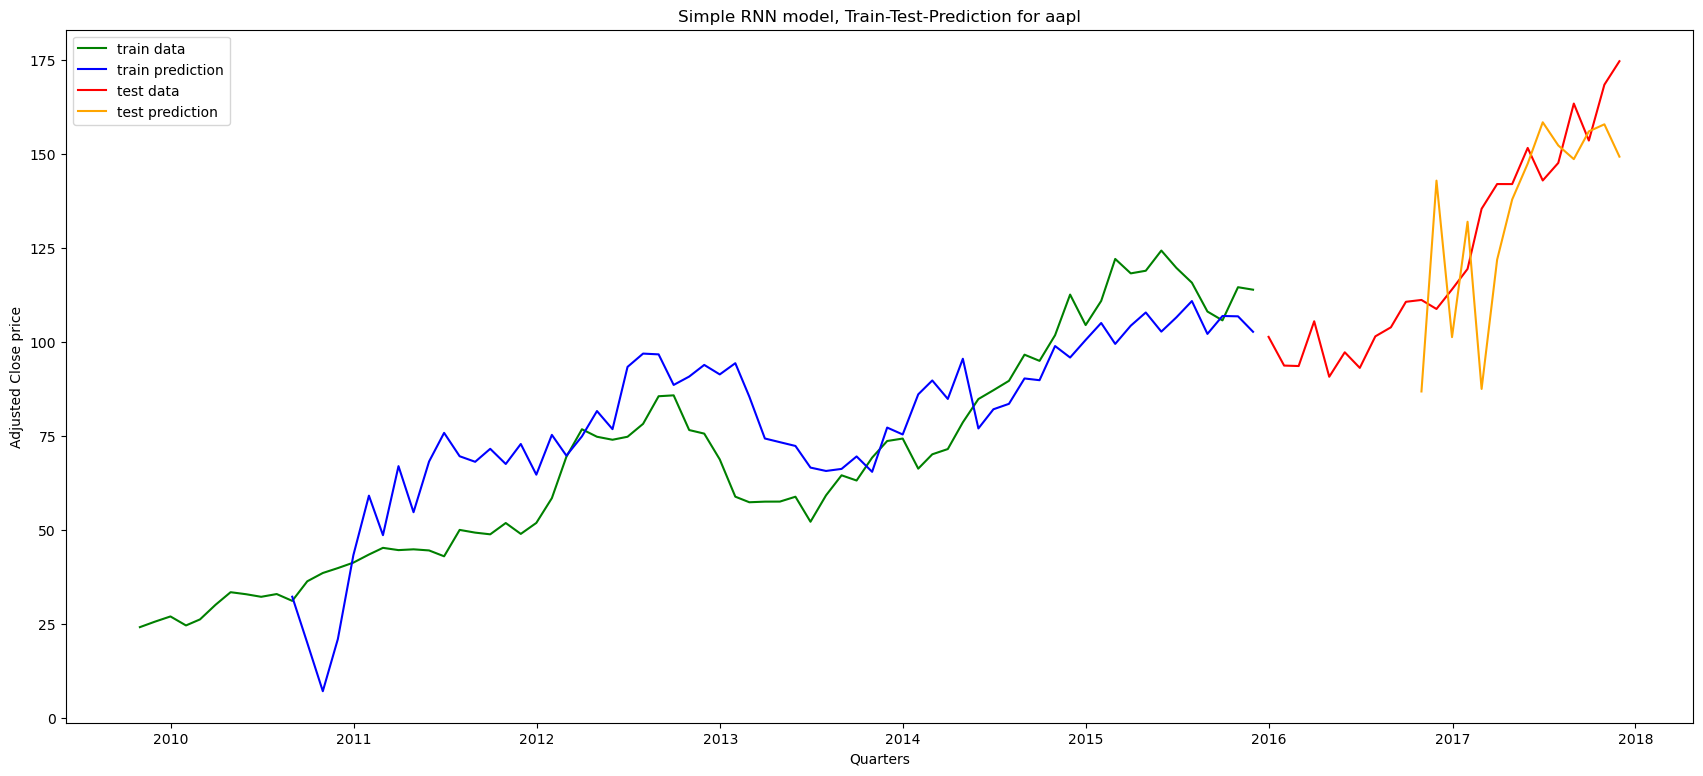

In [24]:
# Combined chart with train and test with predictions
for t in tickers:
    plt.subplots(figsize =(21,9))
    plt.plot(train_dfs[t]['Date'],train_dfs[t]['Close'], color = "g", label = "train data")
    plt.plot(train_dfs[t]['Date'].iloc[Lookback:],y_preds[t], color = "b", label = "train prediction" )
    plt.plot(test_dfs[t]['Date'], test_dfs[t]['Close'], label = "test data", color = "r")
    plt.plot(test_dfs[t]['Date'].iloc[Lookback:], y_test_preds[t], label = "test prediction", color = "orange")
    plt.xlabel("Quarters")
    plt.ylabel("Adjusted Close price")
    plt.title(f"Simple RNN model, Train-Test-Prediction for {t}")
    plt.legend()
    plt.show()

Calculating MSE for train and for test.

In [26]:
mse_train, mse_test = {},{}

for t in tickers:
    # Calculating MSE for train 
    y_trains_unscaled = scales[t].inverse_transform(y_trains[t])
    mse_train[t] = mean_squared_error(y_trains_unscaled, y_preds[t])
    print(f'Mean squared error for {t} train {mse_train[t]:.6}')

    # Calculating MSE for test
    y_test_unscaled = test_scales[t].inverse_transform(y_tests[t])
    mse_test[t] = mean_squared_error(y_test_unscaled, y_test_preds[t])
    print(f'Mean squared error for {t} test {mse_test[t]:.6}')

Mean squared error for aapl train 236.405
Mean squared error for aapl test 432.302


Calculating MSE with actual vs. SMA. SMA serves as a baseline prediction. Should be compared with MSE for test.

In [28]:
sma_window = 8
sma = {}
mse_sma = {}

for t in tickers:
    # Calculating SMA
    sma[t] = stock_dfs[t]['Close'].rolling(sma_window).mean()
    # Calculating MSE for SMA as a baseline
    mse_sma[t] = mean_squared_error(stock_dfs[t]['Close'].iloc[sma_window - 1:], sma[t].dropna())
    print(f'Mean squared error for {t} sma baseline {mse_sma[t]:.6}')

Mean squared error for aapl sma baseline 110.728


Charting everything and SMA in addition

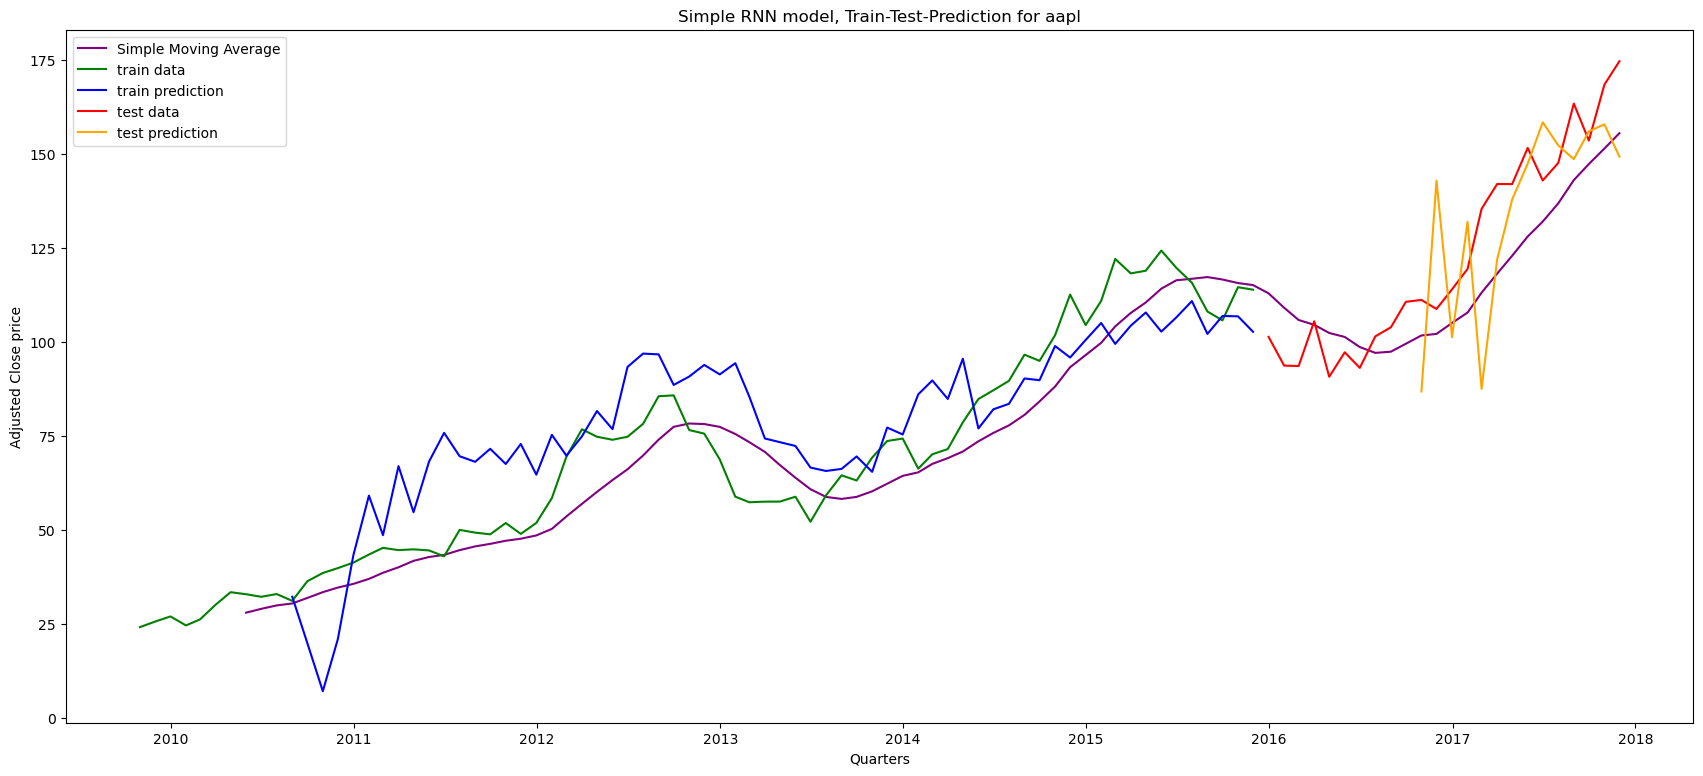

In [30]:
for t in tickers:
    plt.subplots(figsize =(21,9))
    # Adding SMA to plot
    plt.plot(stock_dfs[t]['Date'], sma[t], label = "Simple Moving Average", color = "purple")
    plt.plot(train_dfs[t]['Date'],train_dfs[t]['Close'], color = "g", label = "train data")
    plt.plot(train_dfs[t]['Date'].iloc[Lookback:],y_preds[t], color = "b", label = "train prediction" )
    plt.plot(test_dfs[t]['Date'], test_dfs[t]['Close'], label = "test data", color = "r")
    plt.plot(test_dfs[t]['Date'].iloc[Lookback:], y_test_preds[t], label = "test prediction", color = "orange")
    plt.xlabel("Quarters")
    plt.ylabel("Adjusted Close price")
    plt.title(f"Simple RNN model, Train-Test-Prediction for {t}")
    plt.legend()
    plt.show()